In [1]:
# Import libraries.
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pysindy as ps 
from pysindy.differentiation import FiniteDifference
import scipy.integrate as integrate 
import matplotlib.gridspec as gridspec
import scipy.io as sio

In [2]:
# Plot first three modes in 3D for ground truth and SINDy prediction
def make_3d_plots(x_test, x_test_pred, filename):
    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'}, figsize=(8,8))
    if filename == 'VonKarman':
        ind = -1
    else:
        ind = 2
    plt.plot(x_test[:, 0], x_test[:, 1], x_test[:, ind], 'r')
    plt.plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, ind], 'k')
    ax = plt.gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_axis_off()
    plt.savefig(filename + '_3d.pdf')


# Plot the SINDy fits of X and Xdot against the ground truth
def make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, filename):
    fig = plt.figure(figsize=(30, 30))
    spec = gridspec.GridSpec(ncols=2, nrows=r, figure=fig, hspace=0.0, wspace=0.0)
    for i in range(r):
        plt.subplot(spec[i, 0]) #r, 2, 2 * i + 2)
        plt.plot(t, xdot_test[:, i], 'r')
        plt.plot(t, xdot_test_pred[:, i], 'k--')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.subplot(spec[i, 1])
        plt.plot(t, x_test[:, i], 'r')
        plt.plot(t, x_test_pred[:, i], 'k--')
        ax = plt.gca()
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    plt.savefig(filename + '_fits.pdf')
    
# Plot the objective function vs # iterations
def plot_objective(obj_hist, filename):
    plt.figure(figsize=(6, 6))
    plt.semilogy(obj_hist[1:])
    plt.savefig(filename + '_objective.pdf')

In [3]:
# Define the analytic derivatives for each of the examples in this notebook

# Michaelis–Menten model for enzyme kinetics
def enzyme_deriv(x, t0, jx=0.6, Vmax=1.5, Km=0.3):
    return jx - Vmax * x / (Km + x)


# yeast glycolysis model
def yeast_deriv(x_y_z_t_u_v_w, t0, c1=2.5, c2=-100, c3=13.6769, d1=200, d2=13.6769,
                d3=-6, d4=-6, e1=6, e2=-64, e3=6, e4=16, f1=64, f2=-13, f3=13, f4=-16,
                f5=-100, g1=1.3, g2=-3.1, h1=-200, h2=13.6769, h3=128, h4=-1.28, h5=-32,
                j1=6, j2=-18, j3=-100):
    x, y, z, u, v, w = x_y_z_u_v_w
    return [c1 + c2 * x * v / (1 + c3 * v ** 4), 
            d1 * x * v / (1 + d2 * v ** 4) + d3 * y - d4 * y * w,
            e1 * y + e2 * z + e3 * y * w + e4 *z * v + f5 * t * w, 
            f1 * z + e2 * t + f3 *u + f4 * z * w + f5 * t * w,
            g1 * x + g2 * u, 
            h3 * z + h5 * v + h4 * z * v + h1 * x * v / (1 + h2 * v ** 4), 
            j1 * y + j2 * y * w + j3 * t * w]
    
    
def pendulum_on_cart_deriv(w_x_y_z, t0, m=1, M=1, L1=1, L2=1, F=1, g=9.81):
    w, x, y, z = w_x_y_z
    return [y, z, - ((M + m) * g * np.sin(w) + F * L1 * np.cos(w) + m * L1 ** 2 * np.sin(w) * np.cos(
                w) * y ** 2) / (L1 ** 2 * (M + m - m *np.cos(w) ** 2)),
            m * L1 ** 2 * np.sin(w) * y ** 2 + F * L1 + m * g * np.sin(w) * np.cos(
                w) / (L1 * (M + m - m * np.cos(w)) ** 2)]


def double_pendulum_deriv(w_x_y_z, t0, m1=0.2704, m2=0.2056, a1=0.191, a2=0.1621, L1=0.2667, L2=0.2667, 
                          I1=0.003, I2=0.0011, g=9.81, k1=0, k2=0):
    return [y, z, (L1 * a2 ** 2 * g * m2 ** 2 * np.sin(w) - 2 * L1 * a2 ** 3 * z **2 * m2 **2 * np.sin(
                w - x) + 2 * I2 * L1 * g * m2 * np.sin(w) + L1 * a2 **2 * g * m2 **2 *np.sin(
                w - 2 * x) + 2 * I2 * a1 * g * m1 * np.sin(w) - (L1 * a2 * y * m2) ** 2 * np.sin(
                2 * (w - x)) - 2 * I2 * L1 * a2 * z ** 2 * m2 * np.sin(
                w - x) + 2 * a1 * a2 ** 2 * g * m1 * m2 * np.sin(w)) / (2 * I1 * I2 + (L1 * a2 * m2
                ) ** 2 + 2 * I2 * L1 ** 2 * m2 + 2 * I2 * a1 ** 2 * m1 + 2 * I1 * a2 ** 2 * m2 - (
                L1 * a2 * m2) ** 2 * np.cos(2 * (w - x)) + 2 * (a1 * a2) ** 2 * m1 * m2), 
                (a2 * m2 * (2 * I1 * g * np.sin(
                x) + 2 * L1 ** 3 * y ** 2 * m2 * np.sin(w - x) + 2* L1 ** 2 * g * m2 * np.sin(x) + 2* I1 * L1 * y **2 * np.sin(
                w - x) + 2* a1 ** 2 * g * m1 * np.sin(x) + L1 ** 2 * a2 * z ** 2 * m2 * np.sin(
                 * (w - x)) + 2 * L1 * a1 ** 2 * y ** 2 * m1 * np.sin(w - x) - 2 * L1 ** 2 * g * m2 * np.cos(
                w - x) * np.sin(w) - 2 * L1 * a1 * g * m1 * np.cos(w - x) * np.sin(w))) / ( 2 * (
                I1 * I2 + (L1 * a2 * m2) ** 2 + I2 * L1 ** 2 * m2 + I2 * a1 ** 2 * m1 + I1 * a2 ** 2 * m2 - (L1 * a2 * m2) ** 2 * np.cos(
                w - x) ** 2 + a1 ** 2 * a2 ** 2 * m1 * m2))]


# Definition of the model error for choosing a model at the end
def model_error(xdot_test, Theta, full_coefficients):
    return np.linalg.norm(Theta - Theta @ full_coefficients, axis=0) / np.linalg.norm(Theta, axis=0) 


# Definition of the derivative prediction error for choosing a model at the end
def prediction_error(xdot_test, xdot_test_pred):
    return np.linalg.norm(xdot_test - xdot_test_pred, axis=0) / np.linalg.norm(xdot_test, axis=0)

In [4]:
# define parameters
r = 1
dt = 0.01
T = 5
t = np.arange(0, T + dt, dt)
x0 = np.random.rand(r) - 0.5
x_train = integrate.odeint(enzyme_deriv, x0, t)
x0 = np.random.rand(r)
x_test = integrate.odeint(enzyme_deriv, x0, t)

# define hyperparameters
threshold = 0.0

fd = FiniteDifference()
xdot_train = fd._differentiate(x_train, t)
xdot_test = fd._differentiate(x_test, t)

# Initialize custom SINDy library so that we can have xdot inside it. Using the library
# Found in Equation A1 in the SINDy-PI paper
x_library_functions = [lambda x:1, lambda x: x] #, lambda x, y:x * y, lambda x:x ** 2, 
                     #lambda x, y, z:x * y * z, lambda x, y: x * y ** 2, lambda x: x ** 3,
                     #lambda x, y, z, w: x * y * z * w, lambda x, y, z:x * y * z ** 2,
                     #lambda x, y:x * y ** 3, lambda x:x ** 4]
#library_function_names = ['x', 'xdot']
xdot_library_functions = [lambda x:1, lambda x:x]
sindy_library = ps.SINDyPILibrary(library_functions=x_library_functions, 
                                  xdot_library_functions=xdot_library_functions,
                                  #function_names=library_function_names,
                                  )

# max_iter = 10000 by default here because cvxpy is doing all the work
sindy_opt = ps.SINDyPIoptimizer(threshold=threshold, tol=1e-5, thresholder="l1")
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
    differentiation_method=ps.FiniteDifference(drop_endpoints=True),
)
model.fit(x_train, t=t)

(2,)
(4,)
(499, 1)
-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 2028, constraints m = 2032
          nnz(P) + nnz(A) = 12044
settings: linear system solver = qdldl,
          eps_abs = 1.0e-05, eps_rel = 1.0e-05,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 10000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   6.07e+00   2.55e+05   1.00e-01   2.11e-03s
 200   1.4830e-01   3.63e+00   2.91e-03   1.17e-05   9.65e-03s
 400   3.0391e-02   1.

/usr/local/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py:1061: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


SINDy(differentiation_method=FiniteDifference(drop_endpoints=True),
      feature_library=<pysindy.feature_library.SINDyPI_library.SINDyPILibrary object at 0x7fdcac82e750>,
      feature_names=['x0'], optimizer=SINDyPIoptimizer(threshold=0.0))

['f0(x0)fdot0(xdot0)', 'f0(x0)fdot1(xdot0)', 'f1(x0)fdot0(xdot0)', 'f1(x0)fdot1(xdot0)']
[[-1.37881397e-01  1.96721215e+02  5.84915498e+00  6.49547142e+02]
 [ 5.96094478e-03 -1.40270634e-12 -2.99381147e-02 -3.32633223e+00]
 [ 1.99119157e-01 -3.34015325e+01  2.53281436e-12 -1.11106999e+02]
 [ 1.79214475e-03 -3.00624623e-01 -9.00033236e-03  2.17797022e-15]]
(501, 1)
[1.86250448e+00 2.74722676e+04 2.47351381e+00 2.69266853e+04]
[4.40666638]
[1658.13528263]
[31.10532959]
[5490.03817183]


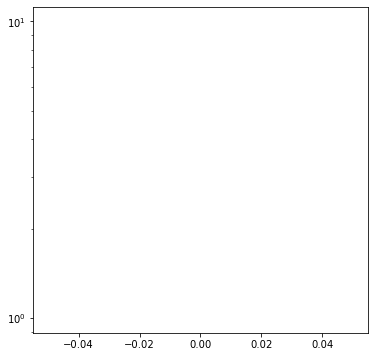

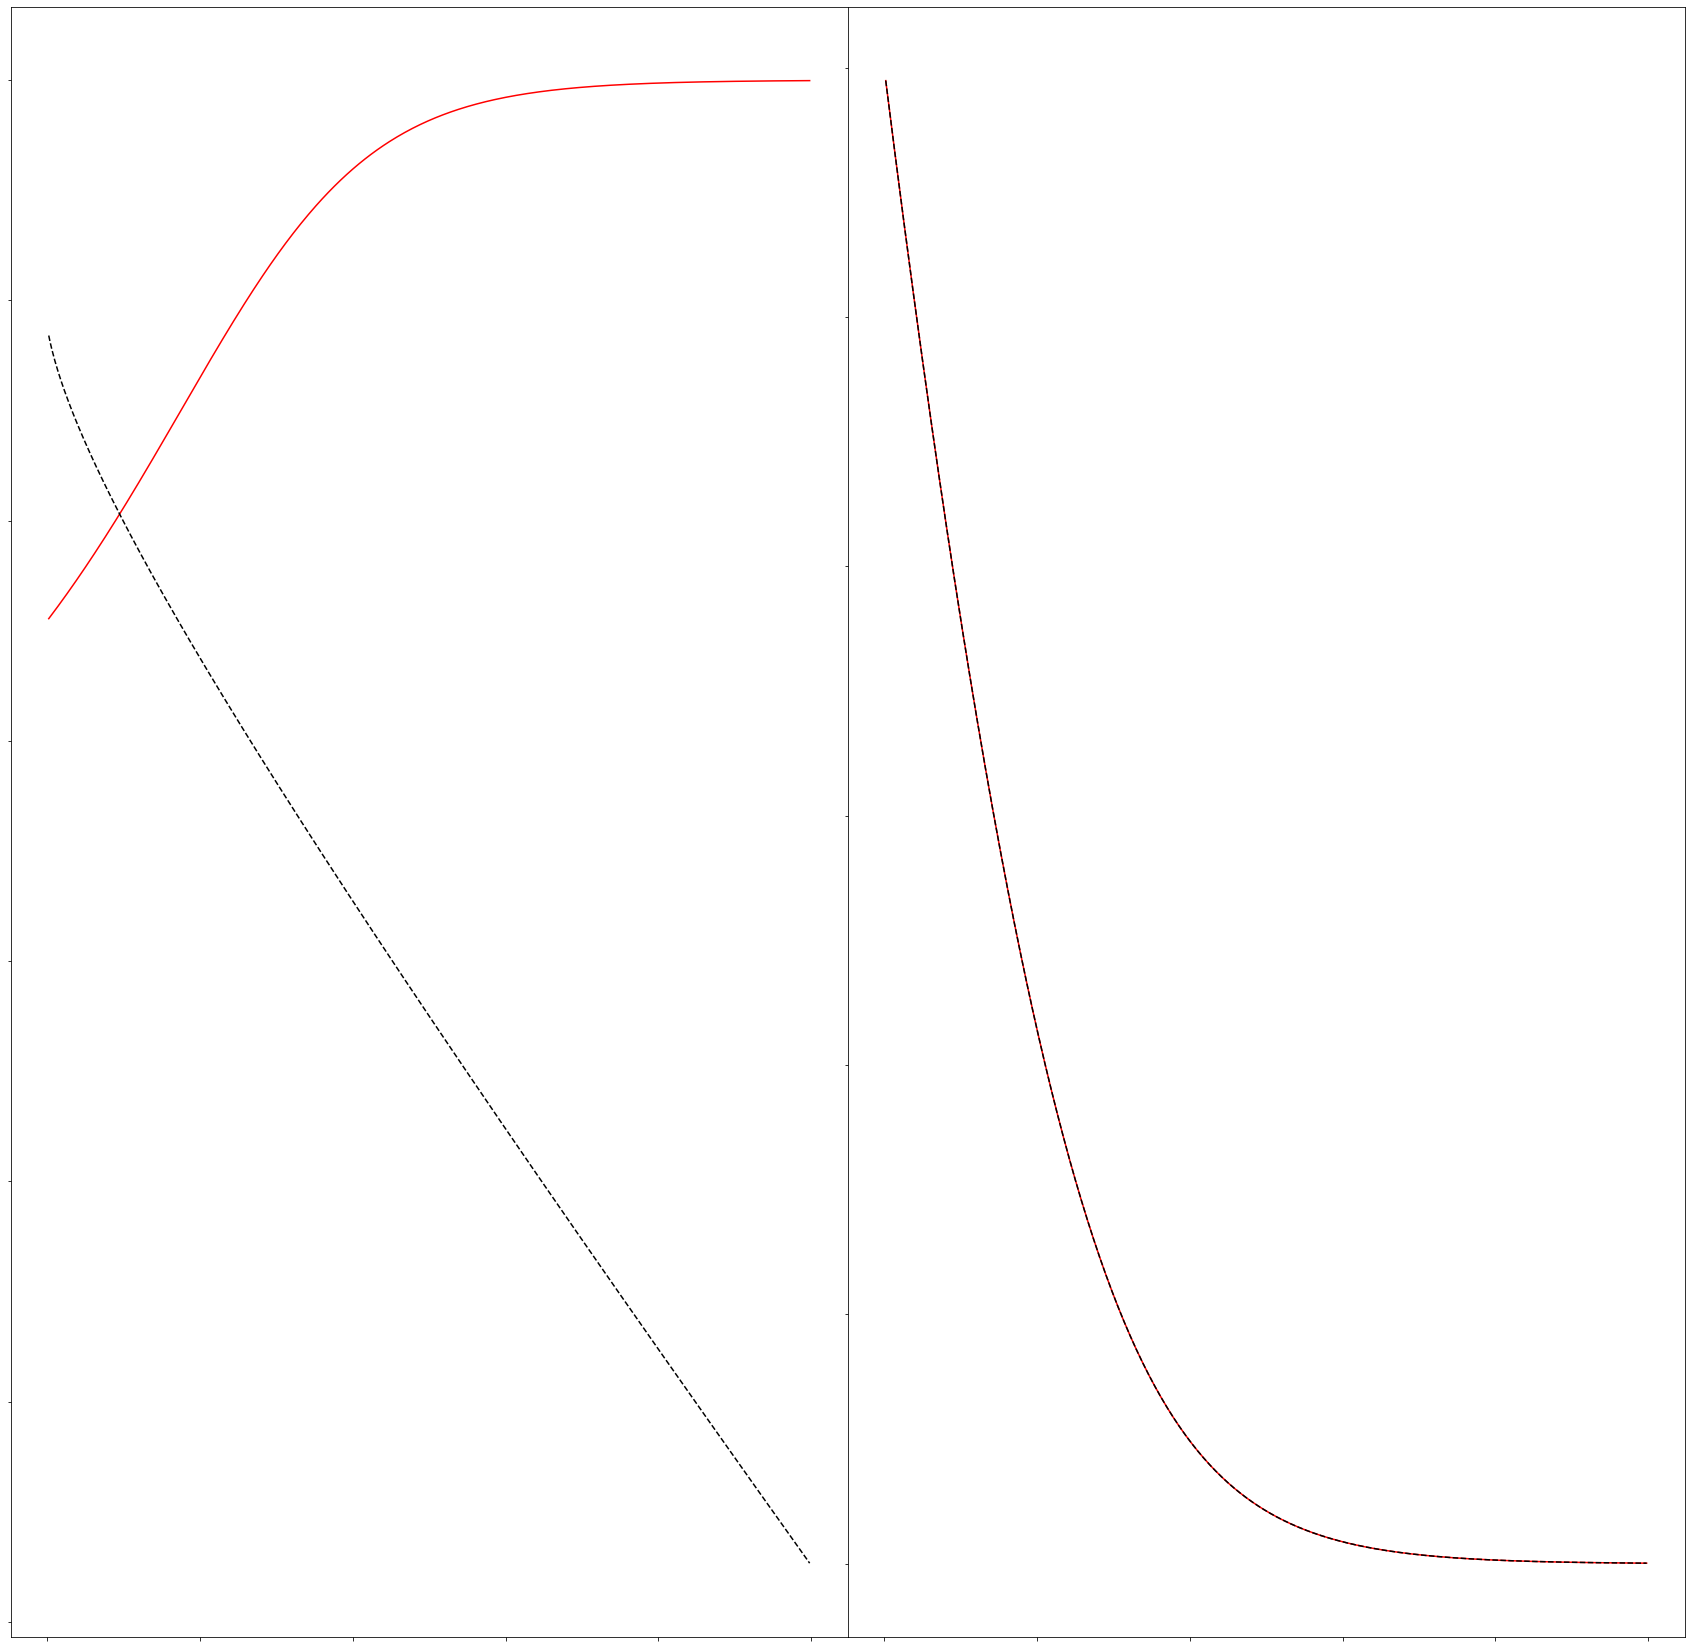

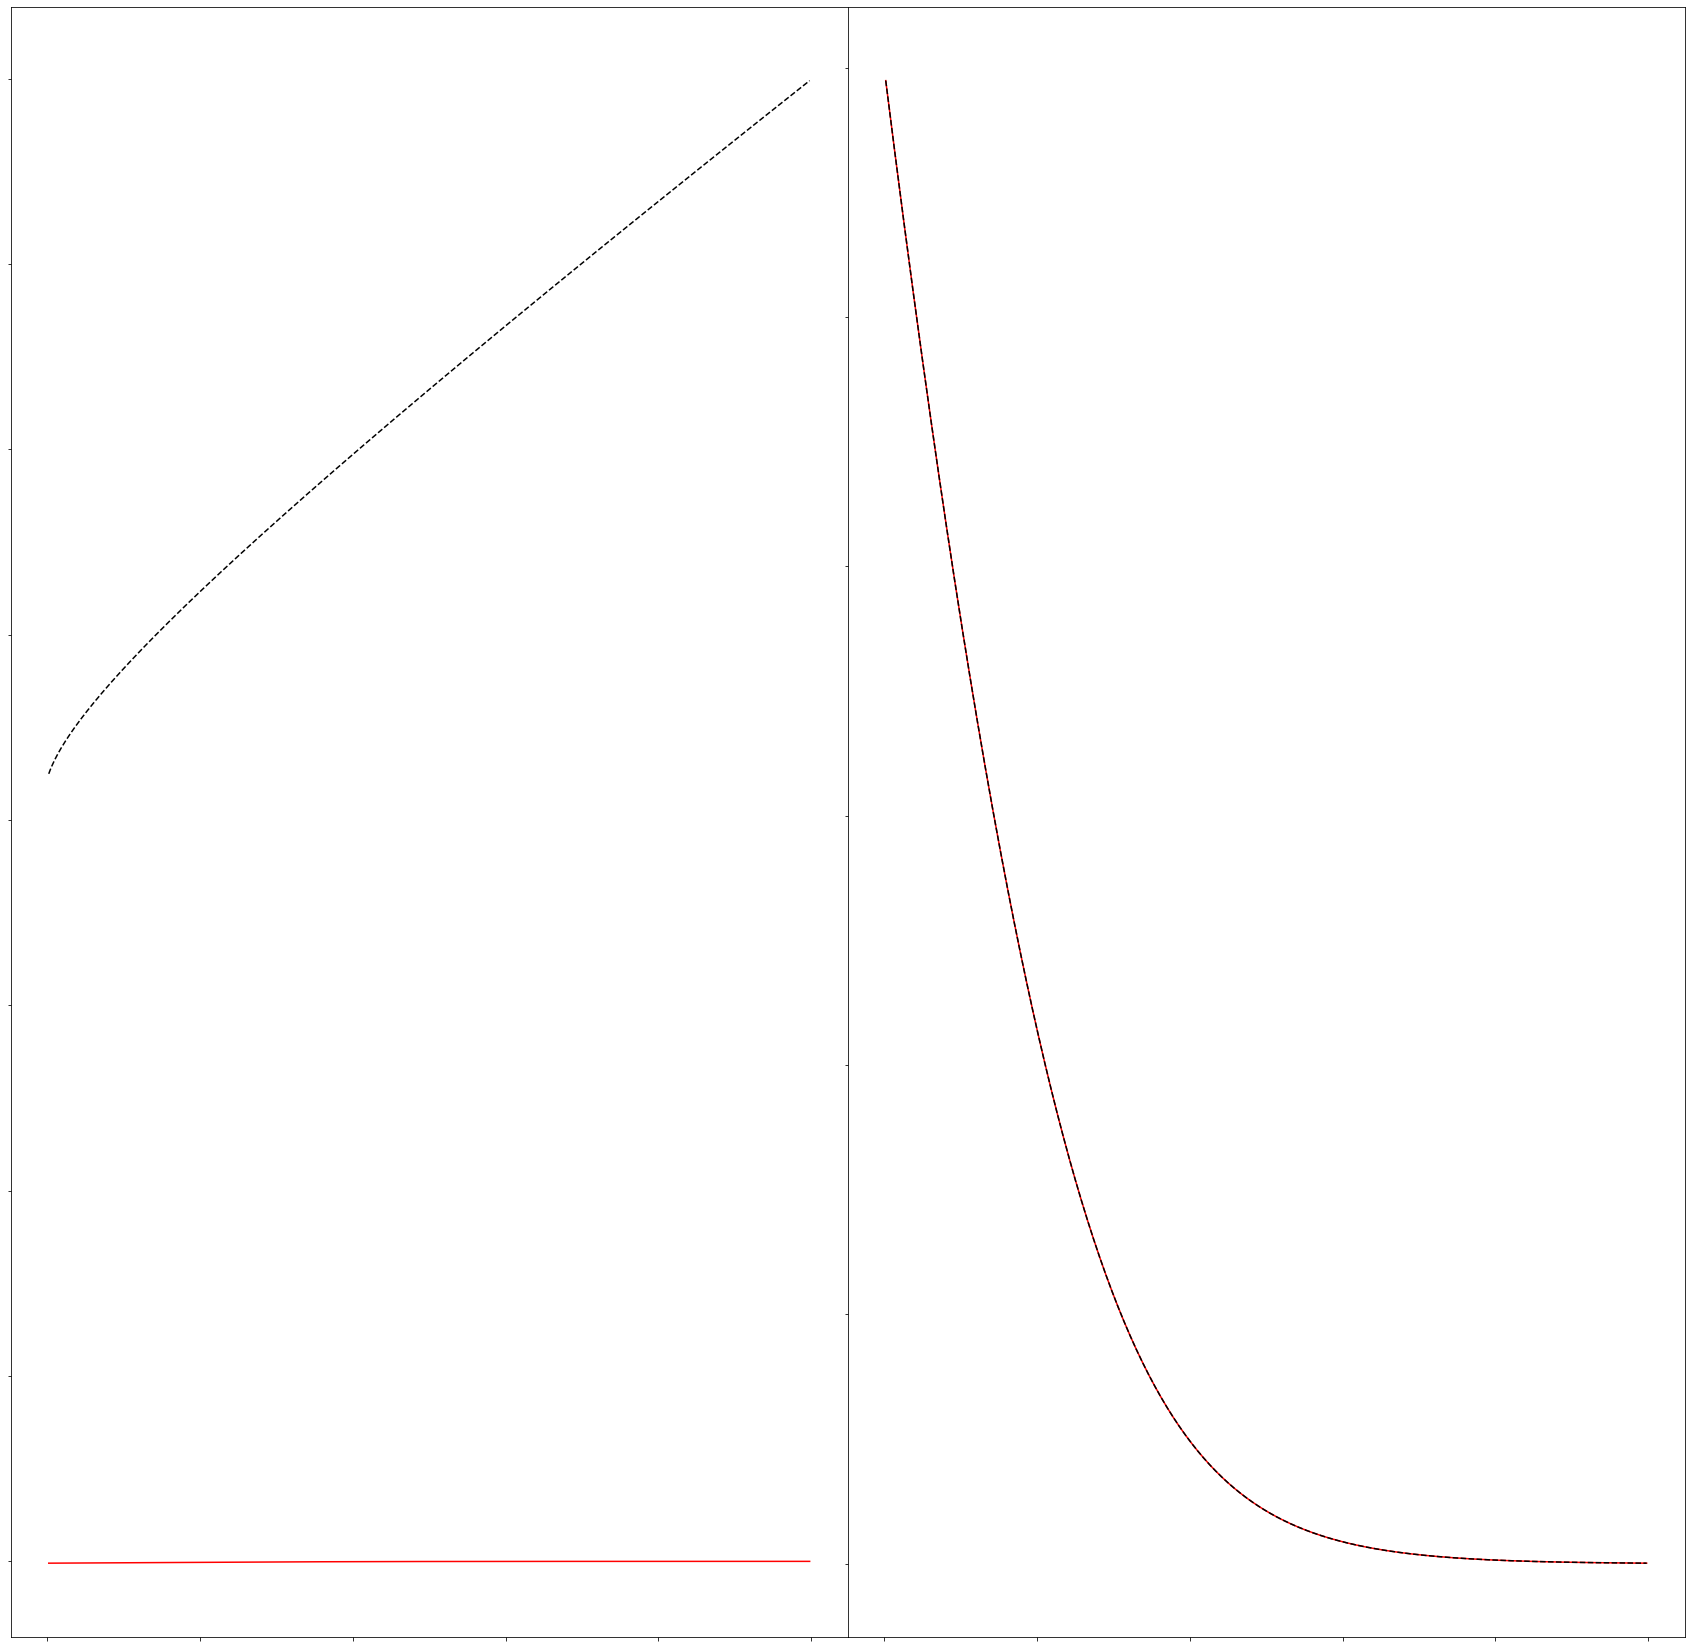

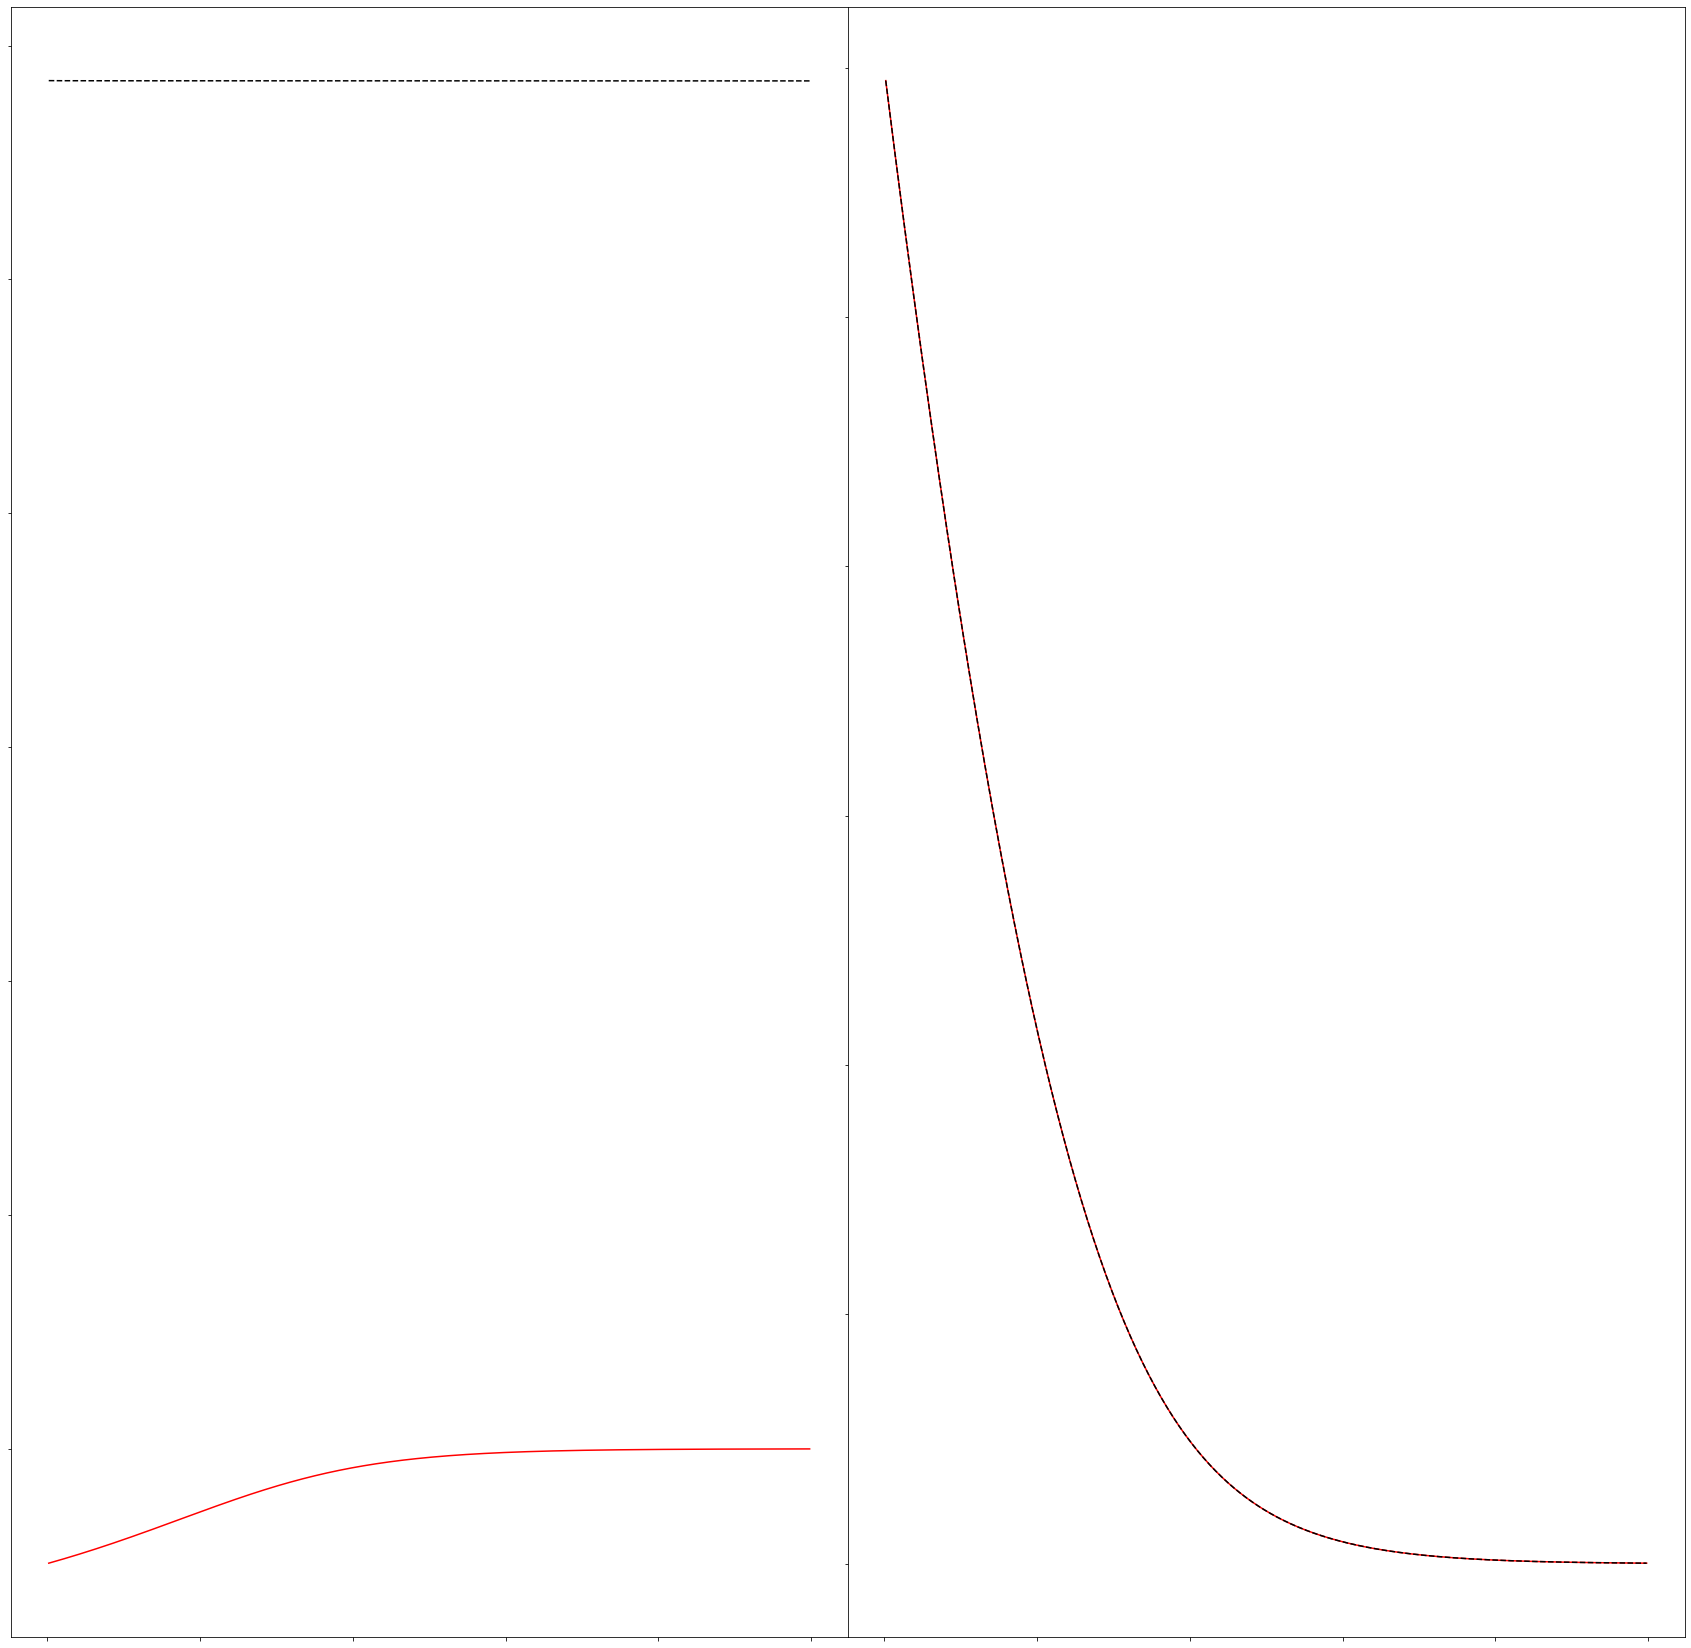

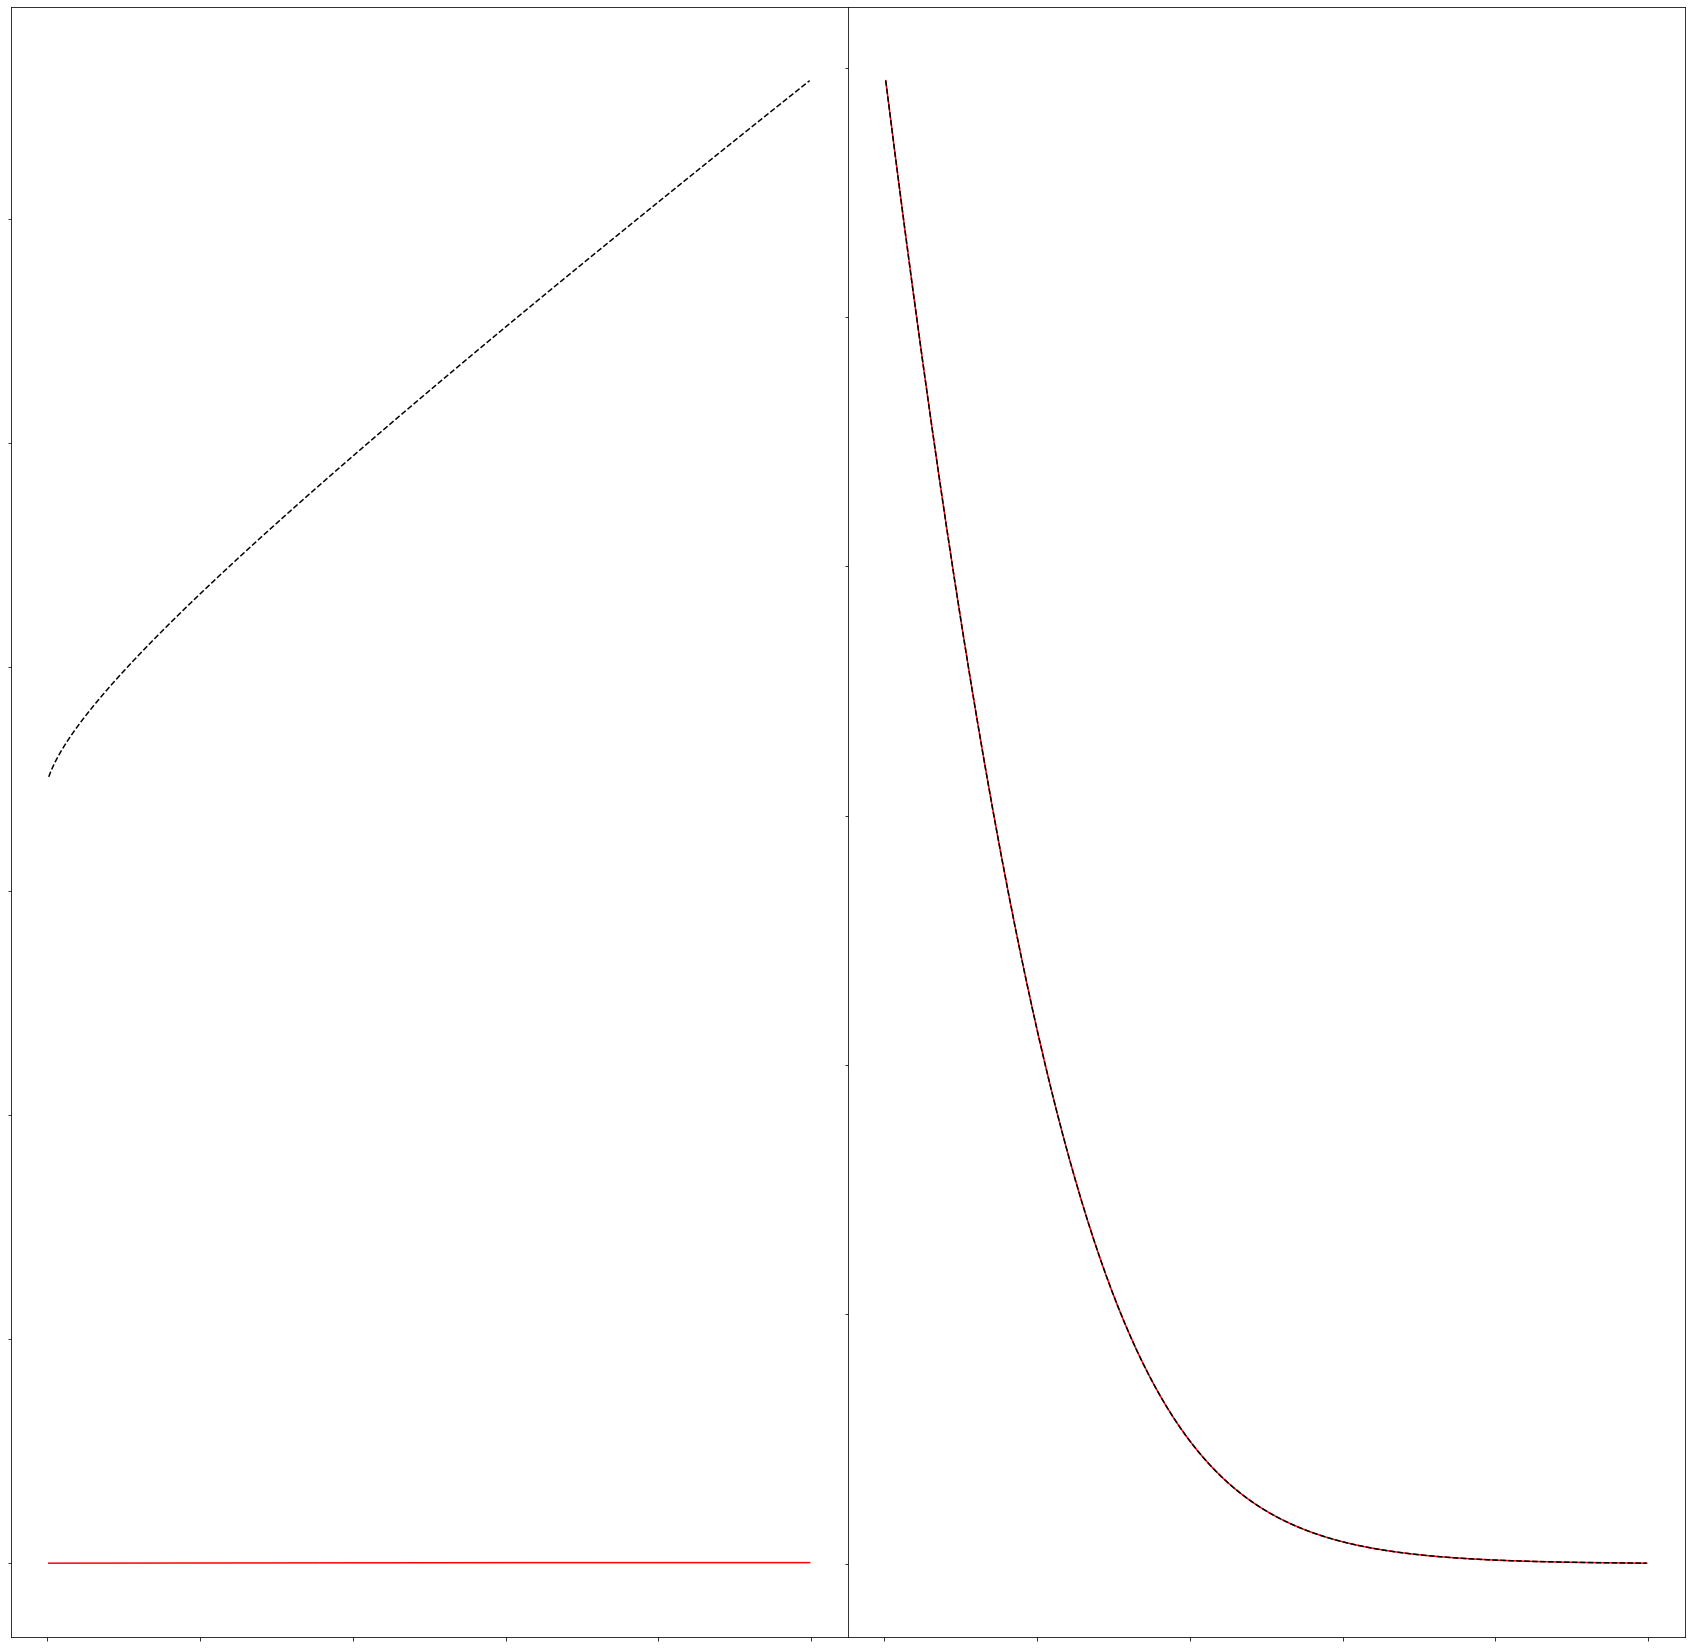

In [6]:
print(model.get_feature_names())
#model.print()
# Don't do this in SINDy-PI... "Xi = model.coefficients().T"
# Do this instead >
print(sindy_opt.coef_)
plot_objective(sindy_opt.objective_history, 'Michaelis–Menten')
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
print(model_error(xdot_test, sindy_opt.Theta, sindy_opt.coef_))
xdot_test = xdot_test[1:-1]
x_test = x_test[1:-1]

for i in range(np.shape(sindy_opt.coef_)[1]):
    xdot_test_pred = np.reshape((sindy_opt.Theta @ sindy_opt.coef_[:, i]), (np.shape(sindy_opt.Theta)[0], 1))
    make_fits(r, t[1:-1], xdot_test, xdot_test_pred, x_test, x_test, "Michaelis–Menten")
    print(prediction_error(xdot_test, xdot_test_pred))
# x_train_pred = model.simulate(x_train[0, :], t)
# x_test_pred = model.simulate(x_test[0, :], t)

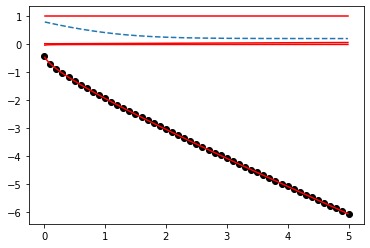

In [20]:
plt.plot(t[1:-1], x_test, '--')
plt.plot(t[::10], x_train[::10], 'ko')
for i in range(4):
    plt.plot(t[1:-1], sindy_opt.Theta[:, i], 'r')

## The problem here is that Theta(X, Xdot) is still using the training data... it needs to use the testing data
## to correctly get Xdot. 